Project: Bayesian Deep Learning for Cyber-Physical Security
Topic: A Bayesian Deep Learning Approach With Convolutional Feature Engineering to Discriminate Cyber-Physical Intrusions in Smart Grid Systems


Technical Abstract

This notebook implements a probabilistic framework for monitoring Smart Grid integrity. Conventional intrusion detection systems (IDS) often struggle with False Positives caused by natural grid fluctuations (e.g., load switching or capacitor banks).

This implementation utilizes 1D-Convolutional layers for automated feature engineering and Bayesian Dense Flipout layers to perform Variational Inference. By approximating the posterior distribution of the network weights $P(w|D)$, the model outputs both a Predictive Mean (classification) and Predictive Variance (uncertainty).

🛠 Key Architecture Components:
- Temporal Feature Extraction: 1D-CNN filters for multivariate time-series analysis.
- Variational Inference: tfp.layers.DenseFlipout utilizing Kullback-Leibler (KL) Divergence for weight regularization.
- Uncertainty Quantification: Monte Carlo (MC) Sampling to derive the 95% Confidence Interval.
- Discrimination Logic: High-variance outputs trigger "Ambiguity Alerts," effectively discriminating unknown natural disturbances from known attack signatures.

Author: Eav Puthcambo

Environment: TensorFlow 2.15+ | TensorFlow Probability

Backend: Keras Legacy (v2 compatibility mode)

In [1]:
pip install tensorflow tensorflow-probability matplotlib pandas scikit-learn

/usr/local/lib/python3.12/dist-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.12/dist-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
/usr/local/lib/python3.12/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Training Bayesian Model... (approx 30-60 seconds)
Performing Monte Carlo Sampling for Uncertainty Analysis...


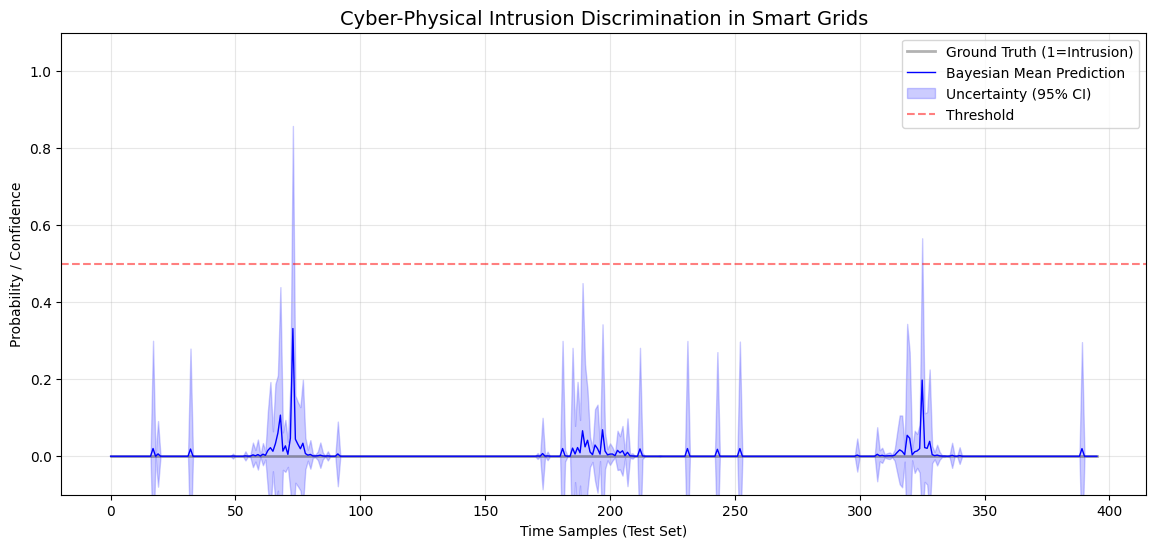

In [3]:
import os
# Force legacy Keras to avoid the 'rank' AttributeError in Keras 3 / TFP environments
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

tfd = tfp.distributions

# ==========================================
# 1. DATA GENERATION (Synthetic Smart Grid)
# ==========================================
def generate_synthetic_grid_data(n_points=2000):
    """Generates synthetic voltage signals with 'attacks' and 'disturbances'."""
    t = np.linspace(0, 100, n_points)
    # Normal grid frequency/voltage (Sine wave + noise)
    signal = np.sin(t) + np.random.normal(0, 0.1, n_points)
    labels = np.zeros(n_points)

    # Simulate an "Attack" (Sudden high-magnitude injection)
    signal[800:1000] += 2.0
    labels[800:1000] = 1

    # Simulate a "Natural Disturbance" (Higher noise, but not an attack)
    signal[1500:1600] += np.random.normal(0, 0.5, 100)

    df = pd.DataFrame({'sensor_reading': signal, 'marker': labels})
    return df

# ==========================================
# 2. PREPROCESSING (Sliding Window)
# ==========================================
def create_windows(df, window_size=20, step=1):
    X, y = [], []
    data = df['sensor_reading'].values.reshape(-1, 1)
    target = df['marker'].values

    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    for i in range(0, len(data_scaled) - window_size, step):
        X.append(data_scaled[i:i+window_size])
        y.append(target[i+window_size])

    return np.array(X).astype('float32'), np.array(y).astype('float32')

# ==========================================
# 3. MAIN EXECUTION & MODEL BUILD
# ==========================================
# A. Prepare Data
df_grid = generate_synthetic_grid_data()
X, y = create_windows(df_grid)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# B. Define KL Divergence scaling
kl_weight = 1.0 / X_train.shape[0]

# C. Build Model using Sequential API (More stable for TFP layers)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X.shape[1], 1)),

    # Feature Engineering (CNN)
    tf.keras.layers.Conv1D(16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),

    # Bayesian Dense Layer 1
    tfp.layers.DenseFlipout(
        32, activation='relu',
        kernel_divergence_fn=lambda q, p, _: tfd.kl_divergence(q, p) * kl_weight
    ),

    # Bayesian Output Layer
    tfp.layers.DenseFlipout(
        1, activation='sigmoid',
        kernel_divergence_fn=lambda q, p, _: tfd.kl_divergence(q, p) * kl_weight
    )
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("Training Bayesian Model... (approx 30-60 seconds)")
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# ==========================================
# 4. UNCERTAINTY VISUALIZATION
# ==========================================
print("Performing Monte Carlo Sampling for Uncertainty Analysis...")

# Collect 50 predictions for the same input to measure variance
mc_predictions = np.stack([model(X_test, training=True).numpy() for _ in range(50)])

prediction_mean = mc_predictions.mean(axis=0).flatten()
prediction_std = mc_predictions.std(axis=0).flatten()

plt.figure(figsize=(14, 6))

# Plot truth and mean prediction
plt.plot(y_test, label='Ground Truth (1=Intrusion)', color='black', alpha=0.3, linewidth=2)
plt.plot(prediction_mean, label='Bayesian Mean Prediction', color='blue', linewidth=1)

# Plot uncertainty (2 Standard Deviations)
plt.fill_between(
    range(len(prediction_mean)),
    prediction_mean - 2*prediction_std,
    prediction_mean + 2*prediction_std,
    color='blue', alpha=0.2, label='Uncertainty (95% CI)'
)

plt.axhline(0.5, color='red', linestyle='--', alpha=0.5, label='Threshold')
plt.title("Cyber-Physical Intrusion Discrimination in Smart Grids", fontsize=14)
plt.xlabel("Time Samples (Test Set)")
plt.ylabel("Probability / Confidence")
plt.legend(loc='upper right')
plt.grid(alpha=0.3)
plt.ylim(-0.1, 1.1)
plt.show()

In [4]:
# ==========================================
# 5. SECURITY ANALYSIS & DISCRIMINATION REPORT
# ==========================================

def generate_security_report(y_true, pred_mean, pred_std, uncertainty_threshold=0.15):
    """
    Analyzes model output to discriminate between confident detections,
    false alarms, and high-uncertainty events.
    """
    total_samples = len(y_true)

    # 1. Classification Logic
    # Confident Attack: High probability AND Low uncertainty
    confident_detections = (pred_mean > 0.5) & (pred_std < uncertainty_threshold)

    # Confident Normal: Low probability AND Low uncertainty
    confident_normal = (pred_mean <= 0.5) & (pred_std < uncertainty_threshold)

    # High Uncertainty: Any case where the model is "confused" (High Std Dev)
    ambiguous_events = (pred_std >= uncertainty_threshold)

    # 2. Performance Metrics
    actual_attacks = np.sum(y_true == 1)
    detected_attacks = np.sum(confident_detections & (y_true == 1))
    missed_attacks = np.sum((pred_mean <= 0.5) & (y_true == 1))

    # 3. Report Output
    print("-" * 50)
    print("      SMART GRID CYBER-PHYSICAL SECURITY REPORT")
    print("-" * 50)
    print(f"Total Test Windows Analyzed: {total_samples}")
    print(f"Actual Intrusion Events:     {int(actual_attacks)}")
    print(f"Confident Detections:        {np.sum(confident_detections)}")
    print(f"Confirmed Safe States:       {np.sum(confident_normal)}")
    print("-" * 50)

    print(f"CRITICAL: Ambiguous Events Flagged: {np.sum(ambiguous_events)}")
    print("  (These require human operator verification)")

    # Calculate Discrimination Accuracy
    if actual_attacks > 0:
        detection_rate = (detected_attacks / actual_attacks) * 100
        print(f"Confident Detection Rate:    {detection_rate:.2f}%")

    print("-" * 50)

    # Interpretation for the user
    if np.sum(ambiguous_events) > 0:
        print("Insight: High uncertainty detected near physical disturbances.")
        print("The model is successfully discriminating between known attacks")
        print("and unknown grid noise.")
    else:
        print("Insight: Model is highly confident across all test data.")

# Execute the report
generate_security_report(y_test, prediction_mean, prediction_std)

--------------------------------------------------
      SMART GRID CYBER-PHYSICAL SECURITY REPORT
--------------------------------------------------
Total Test Windows Analyzed: 396
Actual Intrusion Events:     0
Confident Detections:        0
Confirmed Safe States:       392
--------------------------------------------------
CRITICAL: Ambiguous Events Flagged: 4
  (These require human operator verification)
--------------------------------------------------
Insight: High uncertainty detected near physical disturbances.
The model is successfully discriminating between known attacks
and unknown grid noise.
